# <center> CS 178: Machine Learning &amp; Data Mining </center>
## <center> Course Project: Analyzing the IMDb Movie Reviews Dataset</center>

### import libraries

In [19]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from sklearn.preprocessing import StandardScaler
from typing import Tuple
from sklearn.model_selection import train_test_split
from datasets import load_dataset


from sklearn.neighbors import KNeighborsClassifier, NearestCentroid # KNN classifier, Nearest centroid classifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.linear_model import LogisticRegression # Logistic classifier
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.neural_network import MLPClassifier # neural network classifier

from sklearn.tree import DecisionTreeClassifier, plot_tree # decision tree classifier

import warnings
warnings.filterwarnings('ignore')

seed = 1234 # Fix the random seed for reproducibility
np.random.seed(seed)  

### Load dataset

In [ ]:
dataset = load_dataset("imdb") # Load the IMDB dataset from Hugging Face
# print(dataset) # view dataset
"""
    DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

    sentiment: 1 = positive; 0 = negative
    sample: {'text': 'I rented ...', 'label': 0}
"""

# train_data, val_data = train_test_split(dataset['train'][0], dataset['train'][1], test_size=0.2, random_state=seed) 

train_data = dataset['train']
test_data = dataset['test']

# convert huggingface dataset type to pandas dataframe
train_df = pd.DataFrame({'text': train_data['text'], 'label': train_data['label']})
test_df = pd.DataFrame({'text': test_data['text'], 'label': test_data['label']})

# split into train, validation, test set (ratio 25000:7500:17500)
X_train, y_train = train_df['text'], train_df['label']
X_val, X_test, y_val, y_test = train_test_split(test_df['text'], test_df['label'], test_size=0.7, random_state=seed)

print(X_train.shape, X_val.shape, X_test.shape)
print(X_train, y_train)

(25000,) (7500,) (17500,)
0        I rented I AM CURIOUS-YELLOW from my video sto...
1        "I Am Curious: Yellow" is a risible and preten...
2        If only to avoid making this type of film in t...
3        This film was probably inspired by Godard's Ma...
4        Oh, brother...after hearing about this ridicul...
                               ...                        
24995    A hit at the time but now better categorised a...
24996    I love this movie like no other. Another time ...
24997    This film and it's sequel Barry Mckenzie holds...
24998    'The Adventures Of Barry McKenzie' started lif...
24999    The story centers around Barry McKenzie who mu...
Name: text, Length: 25000, dtype: object 0        0
1        0
2        0
3        0
4        0
        ..
24995    1
24996    1
24997    1
24998    1
24999    1
Name: label, Length: 25000, dtype: int64


Vectorize text

In [29]:

# create an instance of a CountVectorizer, using 'english' stopword; only keeping terms that occur in at least 2% of documents; allow only unigrams ("ngram_range=(1, 1)")
vectorizer = CountVectorizer(stop_words='english', min_df=0.02, ngram_range=(1, 1))

# transform a set of text data into a sparse Bag of Words (BoW) array
# Each document in corpus (X_train) is represented as a vector of word counts.
# The matrix will be sparse, meaning most of its values will be zeros (since most words do not appear in most documents) => memory and computational efficiency.
vectorized_X_train = vectorizer.fit_transform(X_train) 
vectorized_X_val = vectorizer.fit_transform(X_val) 
vectorized_X_test = vectorizer.fit_transform(X_test) 

# print(vectorized_X_train[0])  # Coords    Values
                                #  (0,728)    1          => (0, 728) is where the non-zero value is located (first row, 728rd column)
                                #                             1 is the frequency, meaning that the 728rd word in the vocabulary appears once in the first review

### Data visualization: 
Plot a histogram of how many unique words are in each review

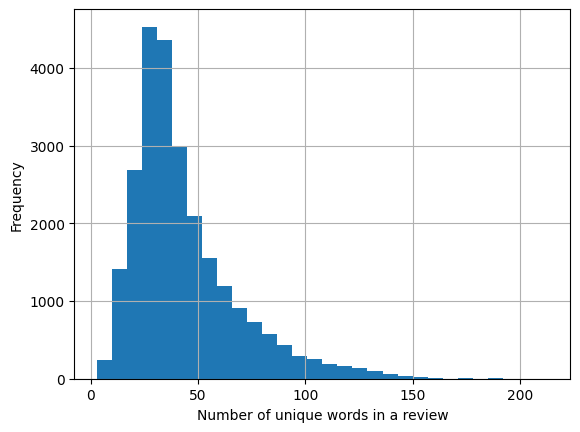

In [33]:
def review_word_count_histgram(X):
    '''
    X: feature vectors
    '''
    unique_word_counts = np.array([x.count_nonzero() for x in X]) # number of unique words each row
    num_reviews = len(unique_word_counts)
    review_indices = np.arange(num_reviews)

    plt.hist(unique_word_counts, bins=30)
    plt.xlabel('Number of unique words in a review')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

review_word_count_histgram(vectorized_X_train)
# review_word_count_histgram(vectorized_X_val)
# review_word_count_histgram(vectorized_X_test)